## ME5413: Autonomous Mobile Robot
### Homework 1: Perception
Due date: 22 February 2024 (Thurs) - 2359

#### Task 1.1 Single-Object Tracking

**Import the necessary packages**

In [1]:
import cv2
import numpy as np
import glob
from utils.load import *
from utils.save import *
from utils.evaluate import *
import matplotlib.pyplot as plt

**Load (and Test) the original frames**

The original frames are stored in the folder `./data`. I define the variable `images` to store the original frames, and then use `cv2.imshow()` to display the original videos.

In [2]:
# define the path to the input video sequence
seq_folder_paths = []
for i in range(5):
    seq_folder_paths.append('data/seq_' + str(i + 1))

##### Using Template Matching to Track a Single Object (Original Approch)
1. Create a template from the first frame
2. Use the template to find the object in the subsequent frames.
   + Notice that several methods are provided in OpenCV (e.g., cv2.TM_CCOEFF, cv2.        TM_CCOEFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED).
3. Draw the rectangle pf the predicted position on the frame.
4. Display the frames with the rectangle.

In [3]:
# Define the function of template matching (original approch)
def template_matching(seq_folder_path):
    # Load the images
    image_files = glob.glob(seq_folder_path + '/img' + '/*.jpg')
    image_files.sort()
    images = []
    for image_file in image_files:
        images.append(cv2.imread(image_file))

    # Create a template from the first frame
    x, y, w, h = load_firsttrack(seq_folder_path + '/firsttrack.txt')
    template = images[0][y:y+h, x:x+w]

    # Select matching method based on the seq_folder_path
    if seq_folder_path == 'data/seq_1':
        matching_method = cv2.TM_CCOEFF_NORMED
    elif seq_folder_path == 'data/seq_2':
        matching_method = cv2.TM_SQDIFF_NORMED
    elif seq_folder_path == 'data/seq_3':
        matching_method = cv2.TM_CCORR_NORMED
    elif seq_folder_path == 'data/seq_4':
        matching_method = cv2.TM_CCOEFF_NORMED
    elif seq_folder_path == 'data/seq_5':
        matching_method = cv2.TM_CCOEFF
    else:
        matching_method = cv2.TM_CCOEFF_NORMED

    # Template matching
    detections = []
    for image in images:
        # Template matching
        res = cv2.matchTemplate(image, template, matching_method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        # copy the image
        image_copy = image.copy()

        # Draw the rectangle around the detected object
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

        # Save the detection
        detections.append([top_left[0], top_left[1], w, h])

        # show the image with the detection
        cv2.imshow('image', image_copy)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

    save_detections(detections, seq_folder_path + '/detections_tm.txt')

**Evaluate and Visualize the Results**

1. Calculate the distance between the center of the predicted position and the ground truth.
2. Calculate the IoU (Intersection over Union) between the predicted position and the ground truth.

Average IoU for seq_1 using template matching: 0.5014470200176465
Average distance for seq_1 using template matching: 115.41229674098946


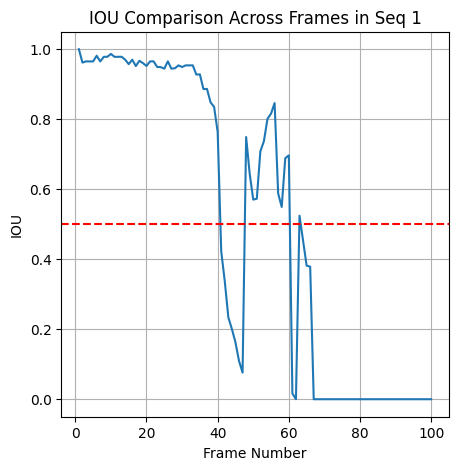

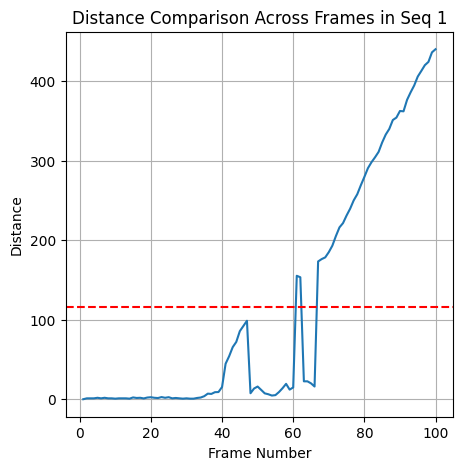

Average IoU for seq_2 using template matching: 0.42584156429441244
Average distance for seq_2 using template matching: 59.40197937224029


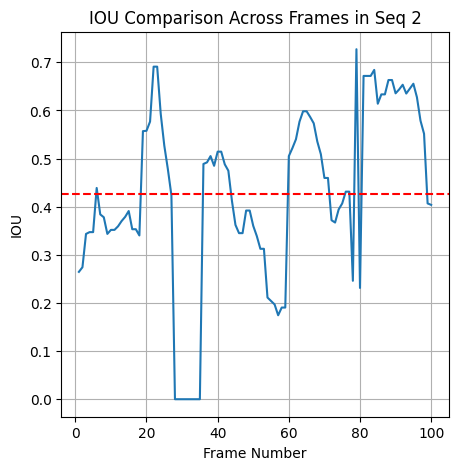

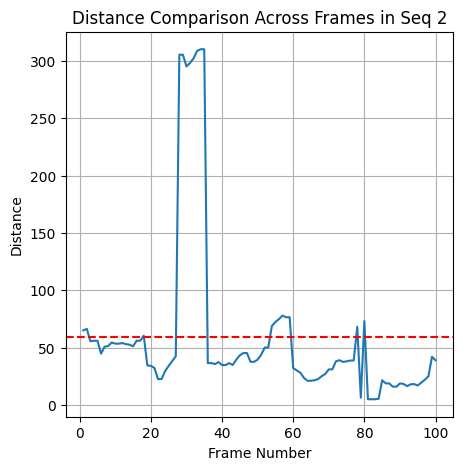

Average IoU for seq_3 using template matching: 0.4190952028452991
Average distance for seq_3 using template matching: 54.53001106279187


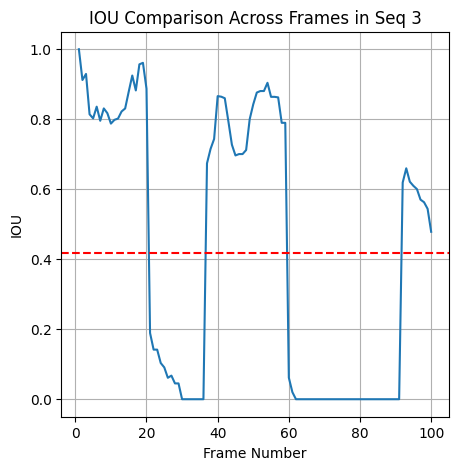

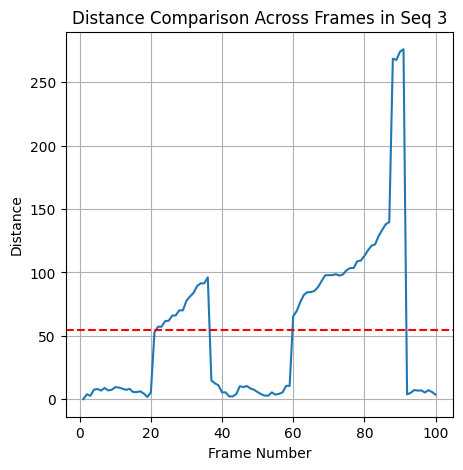

Average IoU for seq_4 using template matching: 0.3982708090227442
Average distance for seq_4 using template matching: 78.58773655239536


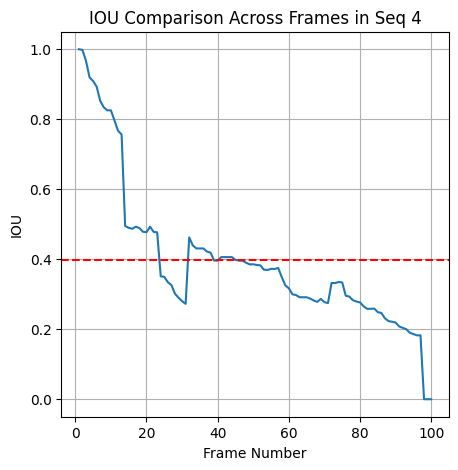

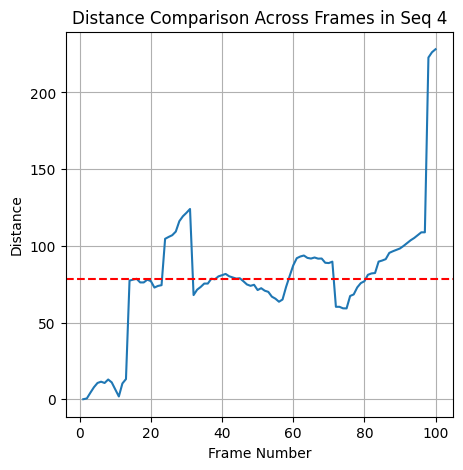

Average IoU for seq_5 using template matching: 0.44555597785777523
Average distance for seq_5 using template matching: 90.16597903976765


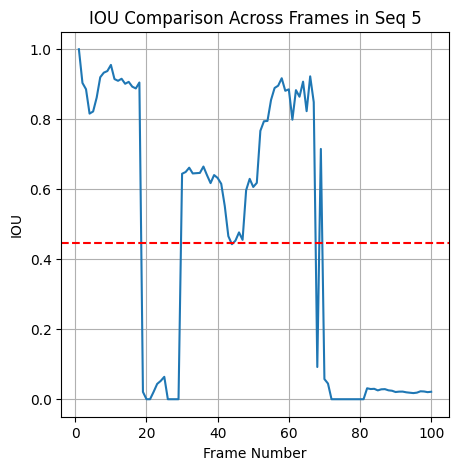

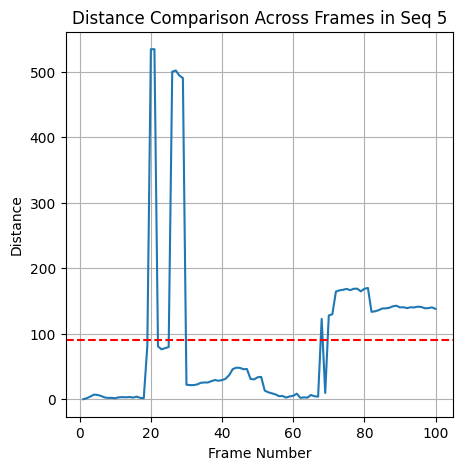

In [4]:
for i in range(5):
    # Define the path to the input video sequence
    seq_folder_path = seq_folder_paths[i]
    template_matching(seq_folder_path)

    # Load the ground truth and the detections
    ground_truth = load_tracks(seq_folder_path + '/groundtruth.txt')
    detections_tm = load_tracks(seq_folder_path + '/detections_tm.txt')

    # Return the average IoU
    average_iou_tm = evaluate_average_iou(detections_tm, ground_truth)
    average_distance_tm = calculate_average_distance(detections_tm, ground_truth)
    print('Average IoU for seq_' + str(i + 1) + ' using template matching: ' + str(average_iou_tm))
    print('Average distance for seq_' + str(i + 1) + ' using template matching: ' + str(average_distance_tm))

    # Visualize the results
    visualize_iou(detections_tm, ground_truth, "IOU Comparison Across Frames in Seq " + str(i + 1))
    visualize_distance(detections_tm, ground_truth, "Distance Comparison Across Frames in Seq " + str(i + 1))

##### Using Template Matching with a Search Region
+ Define a search region around the predicted position based on the previous frame.

In [5]:
# Define the function of template matching with a search region
def template_matching_with_search_region(seq_folder_path):
    # Load the images
    image_files = glob.glob(seq_folder_path + '/img' + '/*.jpg')
    image_files.sort()
    images = []
    for image_file in image_files:
        images.append(cv2.imread(image_file))

    # Create a template from the first frame
    x, y, w, h = load_firsttrack(seq_folder_path + '/firsttrack.txt')
    template = images[0][y:y+h, x:x+w]

    # Define the search region
    search_region = []

    # Select matching method based on the seq_folder_path
    if seq_folder_path == 'data/seq_1':
        matching_method = cv2.TM_CCOEFF_NORMED
        search_region = [1, 4, 12, 1]
    elif seq_folder_path == 'data/seq_2':
        matching_method = cv2.TM_SQDIFF_NORMED
        search_region = [2, 1, 1, 1]
    elif seq_folder_path == 'data/seq_3':
        matching_method = cv2.TM_CCORR_NORMED
        search_region = [5, 1, 8, 1]
    elif seq_folder_path == 'data/seq_4':
        matching_method = cv2.TM_CCOEFF_NORMED
        search_region = [1, 1, 40, 5]
    elif seq_folder_path == 'data/seq_5':
        matching_method = cv2.TM_CCOEFF
        search_region = [10, 10, 10, 10]
    else:
        matching_method = cv2.TM_CCOEFF_NORMED  # Default method
        search_region = [100, 100, 100, 100]

    # Template matching
    detections = []
    prev_loc = (x, y)
    for image in images:
        # Define the region for template matching
        x_region = max(0, prev_loc[0] - search_region[0])
        y_region = max(0, prev_loc[1] - search_region[1])
        w_region = min(image.shape[1], prev_loc[0] + w + search_region[2]) - x_region
        h_region = min(image.shape[0], prev_loc[1] + h + search_region[3]) - y_region

        # Template matching
        res = cv2.matchTemplate(image[y_region:y_region+h_region, x_region:x_region+w_region], template, matching_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        top_left = (max_loc[0] + x_region, max_loc[1] + y_region)

        # copy the image
        image_copy = image.copy()

        # Draw the rectangle around the detected object
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

        # Draw the rectangle of the search region
        cv2.rectangle(image_copy, (x_region, y_region), (x_region + w_region, y_region + h_region), (255, 0, 0), 2)
        
        # Save the detection
        detections.append([top_left[0], top_left[1], w, h])

        # show the image with the detection
        cv2.imshow('image', image_copy)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

        # update the previous location
        prev_loc = top_left
    cv2.destroyAllWindows()

    save_detections(detections, seq_folder_path + '/detections_tm_im.txt')

**Evaluate and Visualize the Results**

Average IoU for seq_1 using template matching: 0.665001590338766
Average distance for seq_1 using template matching: 11.99224324156178


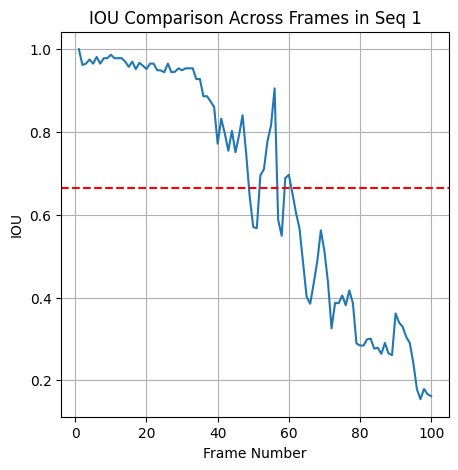

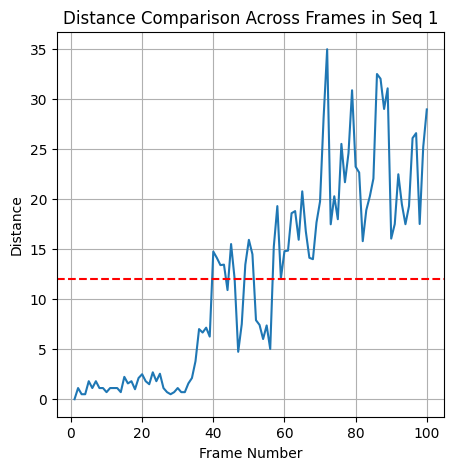

Average IoU for seq_2 using template matching: 0.6127600337652471
Average distance for seq_2 using template matching: 26.964309124631523


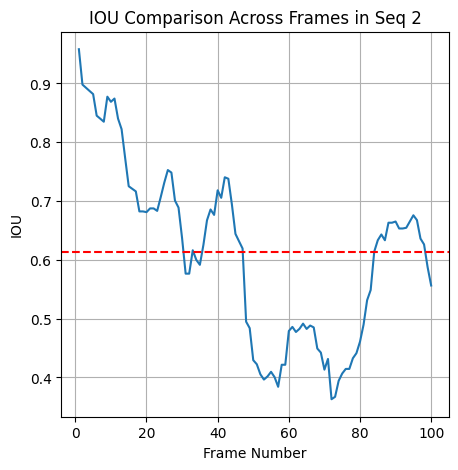

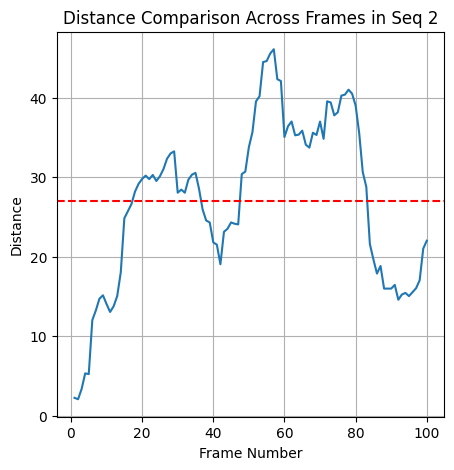

Average IoU for seq_3 using template matching: 0.7364123306259991
Average distance for seq_3 using template matching: 9.256498639433598


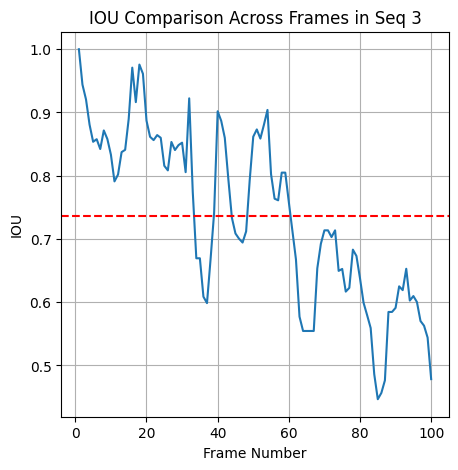

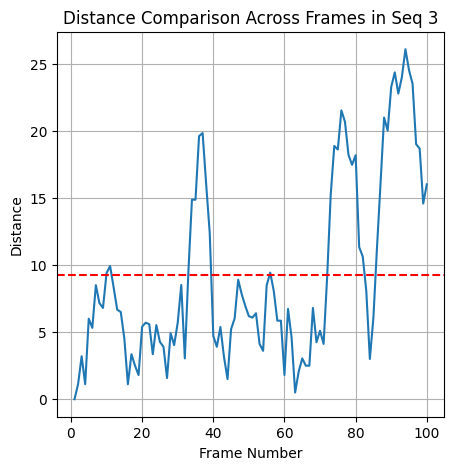

Average IoU for seq_4 using template matching: 0.4631366773511739
Average distance for seq_4 using template matching: 43.122511854559825


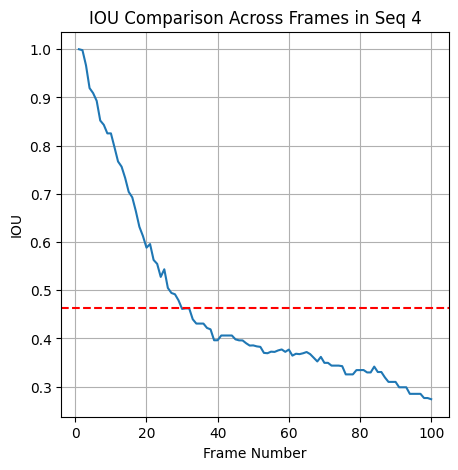

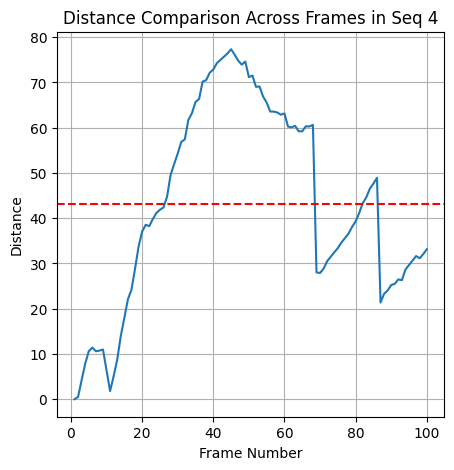

Average IoU for seq_5 using template matching: 0.691740769929789
Average distance for seq_5 using template matching: 18.22926535363609


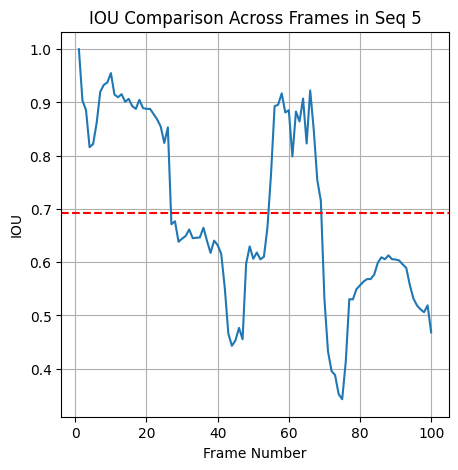

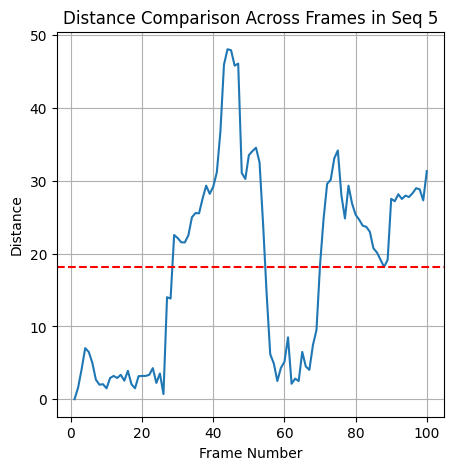

In [6]:
for i in range(5):
    # Define the path to the input video sequence
    seq_folder_path = seq_folder_paths[i]
    template_matching_with_search_region(seq_folder_path)

    # Load the ground truth and the detections
    ground_truth = load_tracks(seq_folder_path + '/groundtruth.txt')
    detections_tm_im = load_tracks(seq_folder_path + '/detections_tm_im.txt')

    # Return the average IoU
    average_iou_tm_im = evaluate_average_iou(detections_tm_im, ground_truth)
    average_distance_tm_im = calculate_average_distance(detections_tm_im, ground_truth)
    print('Average IoU for seq_' + str(i + 1) + ' using template matching: ' + str(average_iou_tm_im))
    print('Average distance for seq_' + str(i + 1) + ' using template matching: ' + str(average_distance_tm_im))

    # Visualize the results
    visualize_iou(detections_tm_im, ground_truth, "IOU Comparison Across Frames in Seq " + str(i + 1))
    visualize_distance(detections_tm_im, ground_truth, "Distance Comparison Across Frames in Seq " + str(i + 1))

##### Using Kalman Filter to Track a Single Object (Measured by Tamplate Matching)
1. Initialize the state and the covariance matrix.
    + State: [x, y, v_x, v_y] representing the position and the velocity of the center of the prediction.
    + Measurement: [x, y] representing the position of the center of the template matching.
2. Predict the state and the covariance matrix.
3. Update the state and the covariance matrix.

In [7]:
def kalman_filter_tmbased(seq_folder_path):
    # Load the images
    image_files = glob.glob(seq_folder_path + '/img' + '/*.jpg')
    image_files.sort()
    images = []
    for image_file in image_files:
        images.append(cv2.imread(image_file))

    # Create a template from the first frame
    x, y, w, h = load_firsttrack(seq_folder_path + '/firsttrack.txt')
    template = images[0][y:y+h, x:x+w]

    # Init the Kalman filter
    kf = cv2.KalmanFilter(4, 2)

    # Initial state (x, y, v_x, v_y) representing the center of the bounding box and the velocity
    kf.statePre = np.array([x + w/2, y + h/2, 0, 0], dtype=np.float32)

    # Transition matrix
    kf.transitionMatrix = np.array([[1, 0, 0.1, 0],
                                    [0, 1, 0, 0.1],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]], dtype=np.float32)

    # Process noise covariance matrix
    kf.processNoiseCov = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, 0.01, 0],
                                [0, 0, 0, 0.01]], dtype=np.float32)

    # Measurement matrix
    kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                    [0, 1, 0, 0]], dtype=np.float32)

    # Measurement noise covariance matrix
    kf.measurementNoiseCov = np.array([[1, 0],
                                      [0, 1]], dtype=np.float32)
    
    # Define the search region
    search_region = []

    # Select matching method based on the seq_folder_path
    if seq_folder_path == 'data/seq_1':
        matching_method = cv2.TM_CCOEFF_NORMED
        search_region = [1, 4, 12, 1]
        kf.measurementNoiseCov = np.array([[0.001, 0],
                                           [0, 0.001]], dtype=np.float32)
    elif seq_folder_path == 'data/seq_2':
        matching_method = cv2.TM_SQDIFF_NORMED
        search_region = [2, 1, 1, 1]
        kf.measurementNoiseCov = np.array([[1, 0],
                                           [0, 1]], dtype=np.float32) * 10
    elif seq_folder_path == 'data/seq_3':
        matching_method = cv2.TM_CCORR_NORMED
        search_region = [5, 1, 8, 1]
        kf.measurementNoiseCov = np.array([[0.01, 0],
                                           [0, 20]], dtype=np.float32)
    elif seq_folder_path == 'data/seq_4':
        matching_method = cv2.TM_CCOEFF_NORMED
        search_region = [1, 1, 40, 5]
        kf.measurementNoiseCov = np.array([[0.6, 0],
                                           [0, 5]], dtype=np.float32)
    elif seq_folder_path == 'data/seq_5':
        matching_method = cv2.TM_CCOEFF
        search_region = [10, 10, 10, 10]
        kf.measurementNoiseCov = np.array([[0.5, 0],
                                            [0, 0.8]], dtype=np.float32)
    else:
        matching_method = cv2.TM_CCOEFF_NORMED  # Default method
        search_region = [100, 100, 100, 100]
    
    # Init the list to store the detections
    detections = []

    # Store the previous location
    prev_loc = (x, y)

    # Kalman filter
    for image in images:
        # Define the region for template matching
        x_region = max(0, prev_loc[0] - search_region[0])
        y_region = max(0, prev_loc[1] - search_region[1])
        w_region = min(image.shape[1], prev_loc[0] + w + search_region[2]) - x_region
        h_region = min(image.shape[0], prev_loc[1] + h + search_region[3]) - y_region

        # Template matching
        res = cv2.matchTemplate(image[y_region:y_region+h_region, x_region:x_region+w_region], template, matching_method)
        _, _, _, max_loc = cv2.minMaxLoc(res)
        top_left = (max_loc[0] + x_region, max_loc[1] + y_region)

        # copy the image
        image_copy = image.copy()

        # Define the measurement
        measurement = np.array([top_left[0] + w/2, top_left[1] + h/2], dtype=np.float32)

        # Update the Kalman Filter
        kf.correct(measurement)

        # Predict the next state
        prediction = kf.predict()
        x_pred, y_pred = int(prediction[0] - w/2), int(prediction[1] - h/2)
        x_pred = max(0, x_pred)
        x_pred = min(image.shape[1] - w, x_pred)
        y_pred = max(0, y_pred)
        y_pred = min(image.shape[0] - h, y_pred)

        # Draw the bounding box
        cv2.rectangle(image_copy, (x_pred, y_pred), (x_pred + w, y_pred + h), (0, 255, 0), 2)

        # Draw the region
        cv2.rectangle(image_copy, (x_region, y_region), (x_region + w_region, y_region + h_region), (255, 0, 0), 2)

        # Draw the trace of the Kalman filter
        cv2.circle(image_copy, (int(prediction[0]), int(prediction[1])), 5, (0, 0, 255), -1)

        # Save the detection
        detections.append([x_pred, y_pred, w, h])

        # show the image with the detection
        cv2.imshow('image', image_copy)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

        # update the previous location
        prev_loc = (x_pred, y_pred)
    
    cv2.destroyAllWindows()

    save_detections(detections, seq_folder_path + '/detections_kf.txt')

**Evaluate and Visualize the Results**

Average IoU for seq_1 using template matching: 0.6618467924646595
Average distance for seq_1 using template matching: 11.540314816449891


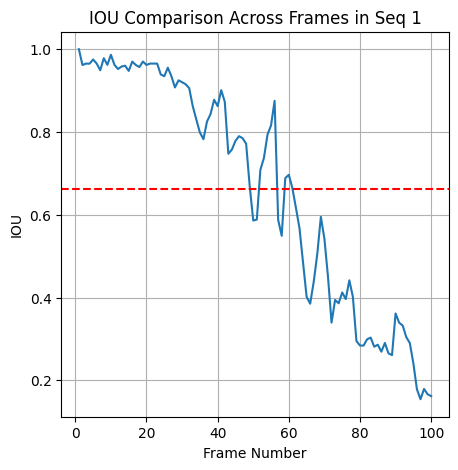

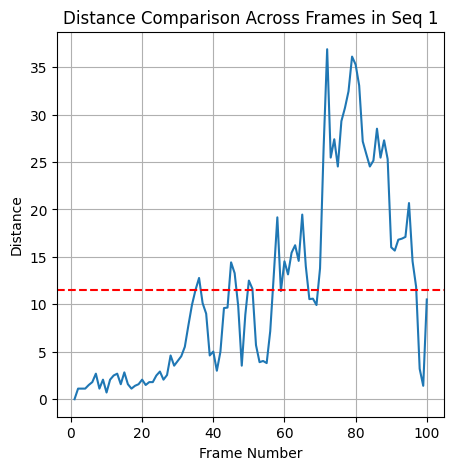

Average IoU for seq_2 using template matching: 0.7242548463530973
Average distance for seq_2 using template matching: 9.947165721296527


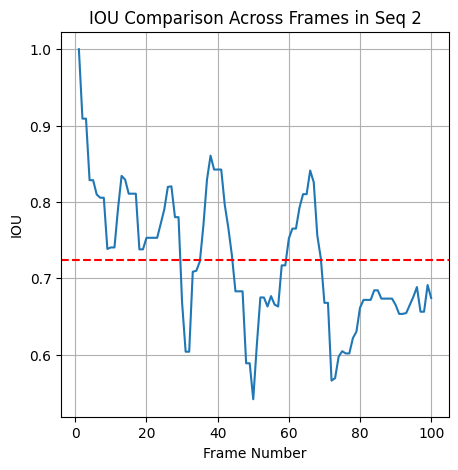

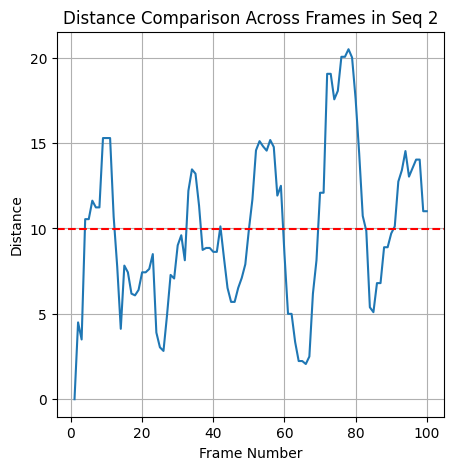

Average IoU for seq_3 using template matching: 0.7260561796658253
Average distance for seq_3 using template matching: 9.343533921210991


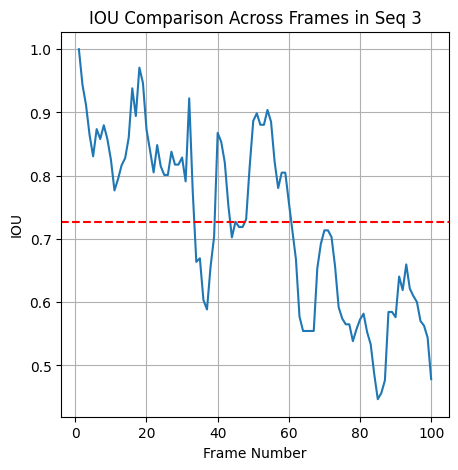

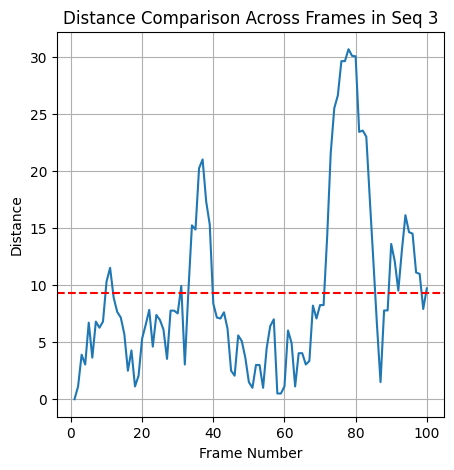

Average IoU for seq_4 using template matching: 0.46276082210330977
Average distance for seq_4 using template matching: 43.56971984847989


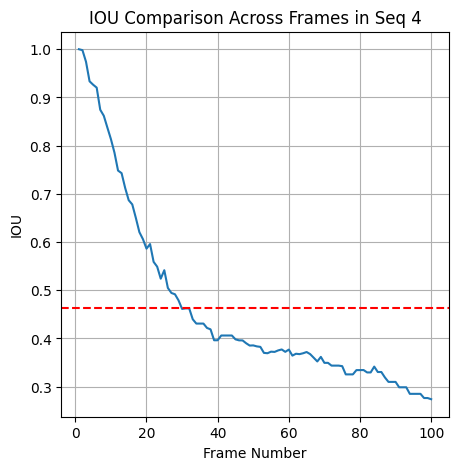

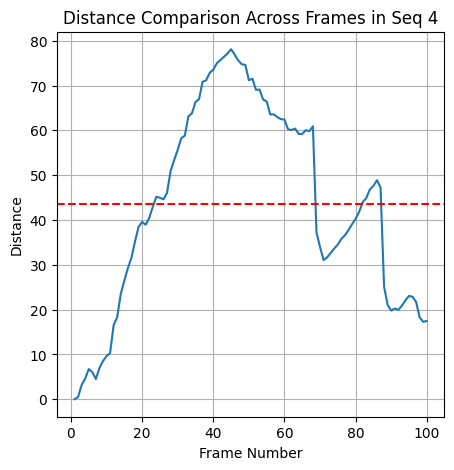

Average IoU for seq_5 using template matching: 0.698086234224734
Average distance for seq_5 using template matching: 18.138866198778068


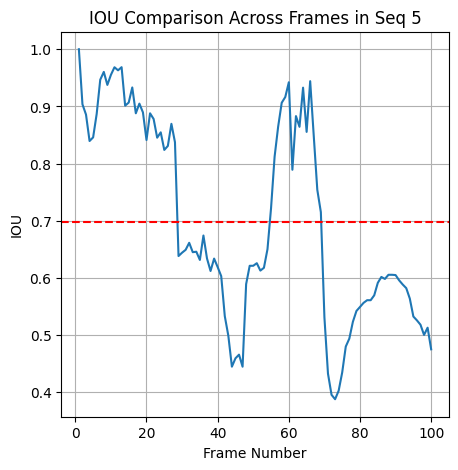

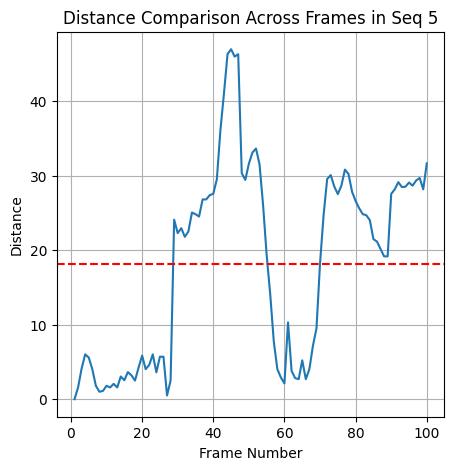

In [8]:
for i in range(5):
    # Define the path to the input video sequence
    seq_folder_path = seq_folder_paths[i]
    kalman_filter_tmbased(seq_folder_path)

    # Load the ground truth and the detections
    ground_truth = load_tracks(seq_folder_path + '/groundtruth.txt')
    detections_kf = load_tracks(seq_folder_path + '/detections_kf.txt')

    # Return the average IoU
    average_iou_kf = evaluate_average_iou(detections_kf, ground_truth)
    average_distance_kf = calculate_average_distance(detections_kf, ground_truth)
    print('Average IoU for seq_' + str(i + 1) + ' using template matching: ' + str(average_iou_kf))
    print('Average distance for seq_' + str(i + 1) + ' using template matching: ' + str(average_distance_kf))

    # Visualize the results
    visualize_iou(detections_kf, ground_truth, "IOU Comparison Across Frames in Seq " + str(i + 1))
    visualize_distance(detections_kf, ground_truth, "Distance Comparison Across Frames in Seq " + str(i + 1))

##### Results Comparison

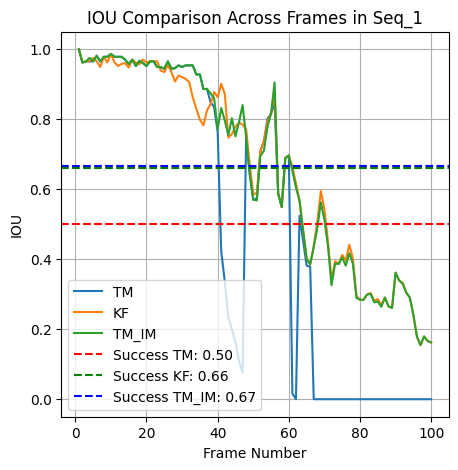

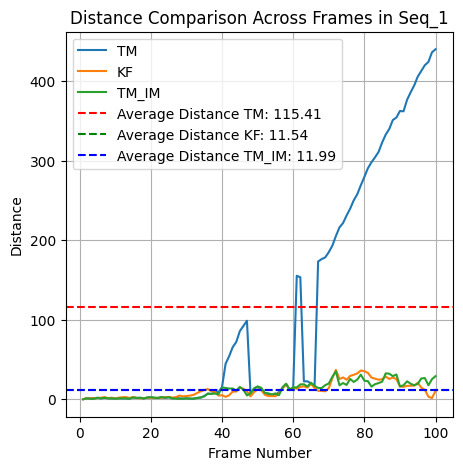

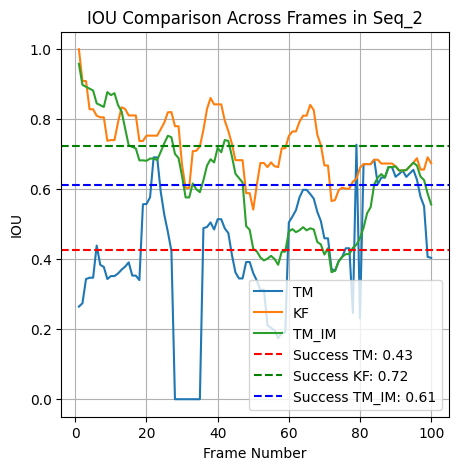

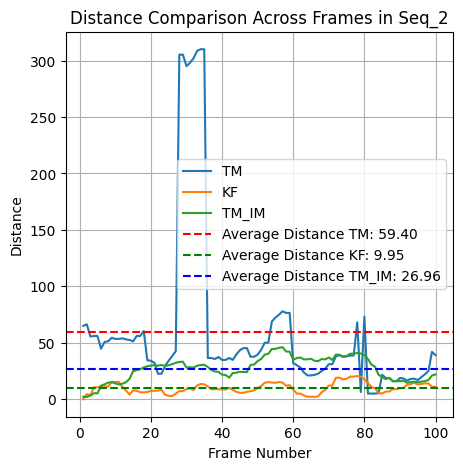

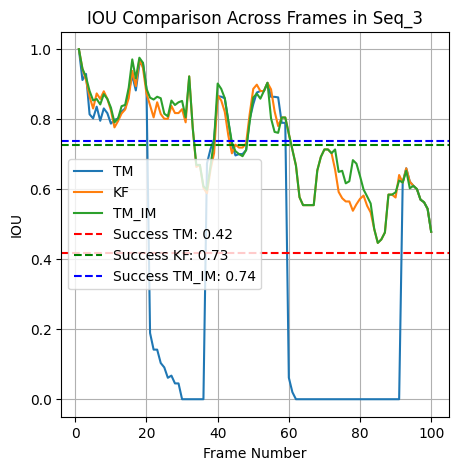

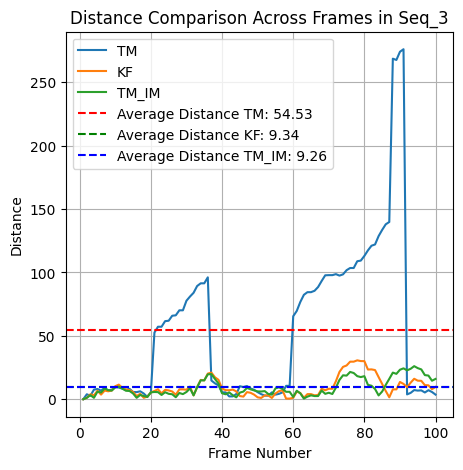

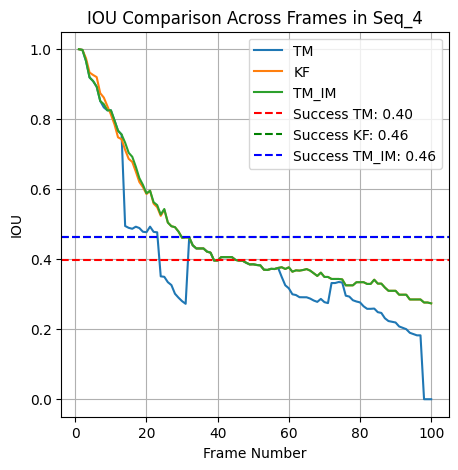

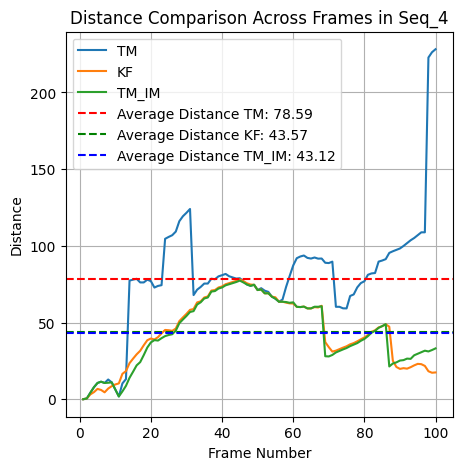

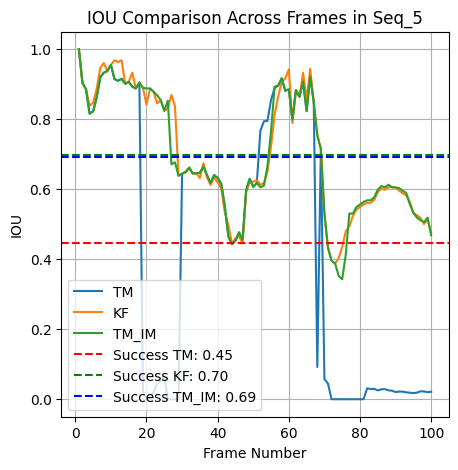

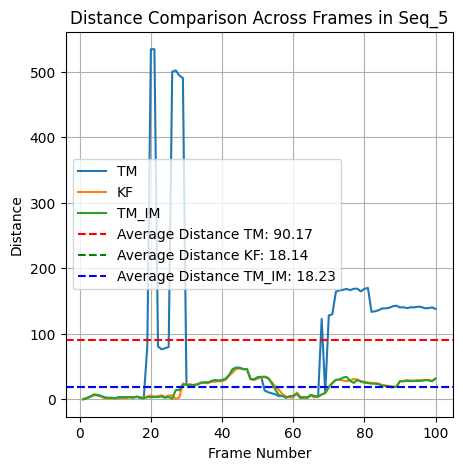

In [9]:
for i in range(1, 6):
    seq_folder = f"data/seq_{i}"
    groundtruth = load_tracks(seq_folder + '/groundtruth.txt')
    detections_tm = load_tracks(seq_folder + '/detections_tm.txt')
    detections_tm_im = load_tracks(seq_folder + '/detections_tm_im.txt')
    detections_kf = load_tracks(seq_folder + '/detections_kf.txt')

    visualize_iou_comparison(detections_tm, detections_tm_im, detections_kf, groundtruth, f"IOU Comparison Across Frames in Seq_{i}")
    visualize_distance_comparison(detections_tm, detections_tm_im, detections_kf, groundtruth, f"Distance Comparison Across Frames in Seq_{i}")